# NNN11 - Cats vs. Dogs Classification
```console
pip install torch opencv-python pandas
```

## 1. Create Annotation File
Data is not always stored in NumPy arrays. Most cases, you will have to organize and annotate the raw data stored in your hard drive. For image data, you want it to be organized as the following way.
``` console
root/dog/xxx.jpg
root/dog/xxy.jpg
root/dog/xxz.jpg

root/cat/123.jpg
root/cat/456.jpg
root/cat/789.jpg
```
Then we can use the following coding block to grab image information and store them in an comma-seperated values (CSV) file.
1. Visit the data directory, grab all images' paths and corresponding categories.
2. Save the paths and categories of images in an `.csv` file

In [ ]:
import sys
import os
from glob import glob
import pandas as pd

# Locate train and test directories
root_dir = os.path.join(sys.path[0], "dataset")  # locate dataset directory from this repo in the whole system
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
categories = ['cats', 'dogs']

# Glob training files
train_cat_files = glob(os.path.join(train_dir, categories[0], "*.jpg"))
train_dog_files = glob(os.path.join(train_dir, categories[1], "*.jpg"))
print(f"There are {len(train_cat_files)} cat images, and {len(train_dog_files)} dog images in the training dataset")
train_image_files = train_cat_files + train_dog_files
train_labels = ['cat'] * len(train_cat_files) + ['dog'] * len(train_dog_files)
train_data_dict = {'path': train_image_files, 'label': train_labels}
df_train = pd.DataFrame(train_data_dict)
# print(df_train)
df_train.to_csv('annotation_train.csv', header=False, index=False)

# Glob test files
test_cat_files = glob(os.path.join(test_dir, categories[0], "*.jpg"))
test_dog_files = glob(os.path.join(test_dir, categories[1], "*.jpg"))
print(f"There are {len(test_cat_files)} cat images, and {len(test_dog_files)} dog images in the test dataset")
test_image_files = test_cat_files + test_dog_files
test_labels = ['cat'] * len(test_cat_files) + ['dog'] * len(test_dog_files)
test_data_dict = {'path': test_image_files, 'label': test_labels}
df_test = pd.DataFrame(test_data_dict)
# print(df_test)
df_test.to_csv('annotation_test.csv', header=False, index=False)

There are 279 cat images, and 278 dog images in the training dataset
There are 70 cat images, and 70 dog images in the test dataset


## 2. Create Dataset
[PyTorch](https://pytorch.org/) as a popuplar deep learning programming framework has a bunch of handy tools that allow you to easily access the data.
1. Inherit the `Dataset` class to build a customized `CatsDogsDataset` class.
2. Instantiate the customized class to a `dataset_train` and `dataset_test` .
3. Further create dataloaders to shuffle the data and access the full matrix of the features and the targets.

0 (100, 100, 3) 0.0
100 (100, 100, 3) 0.0
200 (100, 100, 3) 0.0
300 (100, 100, 3) 1.0
400 (100, 100, 3) 1.0
500 (100, 100, 3) 1.0
556 (100, 100, 3) 1.0


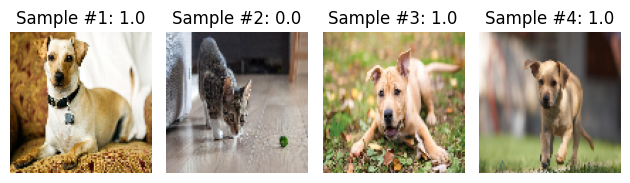

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np


# Create customized dataset
class CatsDogsDataset(Dataset):
    def __init__(self, annotations_file):
        self.imgs_info = pd.read_csv(annotations_file, header=None)

    def __len__(self):
        return len(self.imgs_info)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.imgs_info.iloc[idx, 0]
        image_raw = cv.imread(img_path)
        image_rgb = cv.cvtColor(image_raw, cv.COLOR_BGR2RGB)
        image = cv.resize(image_rgb, (100, 100))
        category = 1. if self.imgs_info.iloc[idx, 1] == 'dog' else 0.
        sample = {'image': image, 'category': category}
        return sample

# Loop training dataset
dataset_train = CatsDogsDataset(annotations_file='annotation_train.csv')
for i, sample in enumerate(dataset_train):
    image = sample['image']
    category = sample['category']
    if not i%100:
        print(i, image.shape, category)
print(i, image.shape, category)

dataset_test = CatsDogsDataset(annotations_file='annotation_test.csv')

# Create shuffled data loader
dataloader_train = DataLoader(dataset_train, batch_size=1000, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1000, shuffle=True)
samples = next(iter(dataloader_train))
fig, axs = plt.subplots(1, 4)
for i in range(4):
    image = samples['image'][i]
    category = samples['category'][i]
    axs[i] = plt.subplot(1, 4, i + 1)
    axs[i].set_title(f'Sample #{i+1}: {category}')
    axs[i].axis('off')
    axs[i].imshow(image)
    plt.tight_layout()


## 3. Preprocess the Data
A typical binary classification dataset is made up with a feature matrix: $\mathbf{X} = [^{(1)}\mathbf{x}, ^{(2)}\mathbf{x}, ..., ^{(M)}\mathbf{x}]^T$. and a target vector $\mathbf{y} = [^{(1)}y, ^{(2)}y, ..., ^{(M)}y]^T$. Where $M$ is the total number of instances in the dataset, $^{(m)}\mathbf{x}$ is a normalized and flattened image array, and $^{(m)}y \in {0, 1}$.

- A colored image is usually represented by a **3-dimensional array with shape $(width, height, 3)$**. Where, $width$ indicates number of pixels on horizontal edge, $height$ indicates number of pixels on vertical edge.
- Usually, we use an **integer ranged 0~255** to describe a pixel, which is the intensity of that color channel.
- At current stage, we would like to convert an image array into a row vector, or a **2d array with shape $(1, width*height*3)$**.

![](https://miro.medium.com/v2/format:webp/1*pFywKuWmz7Xk07OXxPiX2Q.png)

We will access the raw data by extracting it from the dataloaders. Then, process and prepare the raw data so that it can be used in later steps.
1. Separate raw feature array and target array.
2. Reshape feature array and target array.
3. Rescale feature arrary, represent each pixel with a float numbers in range 0~1.

In [ ]:
# Extract features/images and targets/labels
data_train = next(iter(dataloader_train))
data_test = next(iter(dataloader_test))


# Separate features from targets
raw_feature_train = data_train['image'].numpy()
raw_feature_test = data_test['image'].numpy()
raw_target_train = data_train['category'].numpy()
raw_target_test = data_test['category'].numpy()

# Reshape feature matrix to (M, width*height*3), target vector to (M, 1)
reshaped_feature_train = raw_feature_train.reshape(raw_feature_train.shape[0], -1)
reshaped_feature_test = raw_feature_test.reshape(raw_feature_test.shape[0], -1)
reshaped_target_train = raw_target_train.reshape(raw_target_train.shape[0], 1)
reshaped_target_test = raw_target_test.reshape(raw_target_test.shape[0], 1)

# Rescale features within range: 0~1
rescaled_feature_train = reshaped_feature_train / 255
rescaled_feature_test = reshaped_feature_test / 255

# Finalize data to be used later
feature_train = rescaled_feature_train
feature_test = rescaled_feature_test
target_train = reshaped_target_train
target_test = reshaped_target_test


# Sanity check
print(feature_train.shape, feature_test.shape, target_train.shape, target_test.shape)

(557, 30000) (140, 30000) (557, 1) (140, 1)


## 4. Forward Pass

1. Compute first (hidden) layer:
    1. $\mathbf{Z}^{[1]} = \mathbf{X}^{[0]} \cdot \mathbf{W}^{[1]T} + \mathbf{b}^{[1]}$
    2. $\mathbf{X}^{[1]} = \sigma(\mathbf{Z}^{[1]}) = 1 / (1 + e^{-\mathbf{Z}^{[1]}})$
2. Compute second (output) layer:
    1. $\mathbf{Z}^{[2]} = \mathbf{X}^{[1]} \cdot \mathbf{w}^{[2]T} + b^{[2]}$
    2. $\mathbf{\hat{y}} = \sigma(\mathbf{Z}^{[2]}) = 1 / (1 + e^{-\mathbf{Z}^{[2]}})$

In [ ]:
def sigmoid(x):
    """ Sigmoid function
    Args:
        x: independent variable, could be an arrary of any shape or a scalar.
    Returns:
        y: dependent variable, could be an arrary of any shape or a scalar.
    """
    y = 1 / (1 + np.exp(-x))
    return y

def linear(feature, weight, bias):
    return np.dot(feature, weight.T) + bias

def forward(feature_0, params):
    """ Logistic model function
    Args:
        feature: feature matrix, 2d-array with shape (# samples, # pixels)
        params: a dictionary contians all weights (W_1, w_2) and biases (b_1, b_2)
    Returns:
        prediction: model predicted value, a 2-D numpy array with shape (# samples, 1)
    """
    Z_1 = linear(feature_0, params['W_1'], params['b_1'])
    feature_1 = sigmoid(Z_1)
    Z_2 = linear(feature_1, params['w_2'], params['b_2'])
    prediction = sigmoid(Z_2)
    return prediction, feature_1


# Sanity check
np.random.seed(3321)
X0 = np.random.normal(size=(10, 8))  # dummy input, 8 samples, 10 features in each sample.
W1 = np.random.normal(size=(5, 8))  # First layer weight matrix, (num_1nd_layer_features, num_input_layer_features)
b1 = np.random.normal(size=(1, 5))  # First layer bias vector, (1, num_1st_layer_features)
w2 = np.random.normal(size=(1, 5))  # Second layer weight vector, (1, num_2nd_layer_features)
b2 = np.random.normal()  # Second layer bias, scalar
dummy_params = {
    'W_1': W1,
    'b_1': b1,
    'w_2': w2,
    'b_2': b2,
}
yhat, X1 = forward(X0, dummy_params)
print(yhat)
print(yhat.shape)  # (10, 1)
print(X1.shape)  # (10, 5)

[[0.49603533]
 [0.49767655]
 [0.4342204 ]
 [0.29758724]
 [0.33296668]
 [0.32336101]
 [0.51174221]
 [0.61595378]
 [0.51984815]
 [0.19275071]]
(10, 1)
(10, 5)


## 5. Binary Cross Entropy
It is OK to use a Mean square error function to compute the loss (difference between target and prediction). It is better to use a binary cross entropy function to compute the loss for a binary classification problem.

#### $\mathcal{L}(\mathbf{\hat{y}}, \mathbf{y}) = \frac{1}{M} \Sigma [-\mathbf{\hat{y}} \log \mathbf{y} - (1 - \mathbf{\hat{y}}) \log(1 - \mathbf{y})]$


In [ ]:
def binary_cross_entropy_loss(prediction, target):
    """
    Binary Cross Entropy function
        Args:
            prediction: model predicted value, a 2-D numpy array with shape (# samples, 1)
            target: labeled value from data set, a 2-D numpy array with shape (# samples, 1)
        Returns:
            loss_value: averaged CE error, a scalar
    """
    loss_value = -np.mean(target * np.log(prediction) + (1 - target) * np.log(1 - prediction))
    return loss_value

# Sanity check
np.random.seed(3321)
print(binary_cross_entropy_loss(yhat, np.random.randint(0, 2, size=(10, 1))))


0.7463187674914531


## 6. Backpropagation

### 2nd Layer:

### $\frac{\partial \mathcal{L}}{\partial \mathbf{w}^{[2]}} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \cdot \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{Z}^{[2]}} \cdot \frac{\partial \mathbf{Z}^{[2]}}{\partial \mathbf{w}^{[2]}} = \frac{1}{M} (\mathbf{\hat{y} - y})^T \cdot \mathbf{X}^{[1]}$
### $\frac{\partial \mathcal{L}}{\partial b^{[2]}} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \cdot \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{Z}^{[2]}} \cdot \frac{\partial \mathbf{Z}^{[2]}}{\partial b^{[2]}} = \frac{1}{M} \Sigma (\mathbf{\hat{y} - y})$
### $\frac{\partial \mathcal{L}}{\partial \mathbf{X}^{[1]}} = \frac{\partial \mathcal{L}}{\partial \mathbf{\hat{y}}} \cdot \frac{\partial \mathbf{\hat{y}}}{\partial \mathbf{Z}^{[2]}} \cdot \frac{\partial \mathbf{Z}^{[2]}}{\partial \mathbf{X}^{[1]}} = (\mathbf{\hat{y} - y}) \cdot \mathbf{w}^{[2]}$

### 1st Layer:

### $\frac{\partial \mathcal{L}}{\partial \mathbf{W}^{[1]}} = \frac{\partial \mathcal{L}}{\partial \mathbf{X}^{[1]}} \cdot \frac{\partial \mathbf{X}^{[1]}}{\partial \mathbf{Z}^{[1]}} \cdot \frac{\partial \mathbf{Z}^{[1]}}{\partial \mathbf{w}^{[1]}} = [(\mathbf{\hat{y} - y}) \cdot \mathbf{w}^{[2]} * \mathbf{X}^{[1]} * (1 - \mathbf{X}^{[1]})]^T \cdot \mathbf{X}^{[0]}$
### $\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{[1]}} = \frac{\partial \mathcal{L}}{\partial \mathbf{X}^{[1]}} \cdot \frac{\partial \mathbf{X}^{[1]}}{\partial \mathbf{Z}^{[1]}} \cdot \frac{\partial \mathbf{Z}^{[1]}}{\partial \mathbf{b}^{[1]}} = \frac{1}{M} \Sigma (\mathbf{\hat{y} - y}) \cdot \mathbf{w}^{[2]} * \mathbf{X}^{[1]} * (1 - \mathbf{X}^{[1]}) \text{, axis=0}$



Iteration 1 training loss: 0.6931472656902652, test loss: 0.6931471404338816 
train accuracy: 0.4991023339317774, test accuracy: 0.5
Iteration 2 training loss: 0.6931470813397187, test loss: 0.6931471444920269 
train accuracy: 0.5008976660682226, test accuracy: 0.5
Iteration 3 training loss: 0.6931469174476007, test loss: 0.6931471582470322 
train accuracy: 0.5008976660682226, test accuracy: 0.5
Iteration 4 training loss: 0.693146771719409, test loss: 0.6931471800285081 
train accuracy: 0.5008976660682226, test accuracy: 0.5
Iteration 5 training loss: 0.6931466421179653, test loss: 0.693147208387017 
train accuracy: 0.5008976660682226, test accuracy: 0.5
Iteration 6 training loss: 0.6931465268345594, test loss: 0.693147242067357 
train accuracy: 0.5008976660682226, test accuracy: 0.5
Iteration 7 training loss: 0.6931464242633292, test loss: 0.6931472799849512 
train accuracy: 0.5008976660682226, test accuracy: 0.5
Iteration 8 training loss: 0.693146332978514, test loss: 0.6931473212049

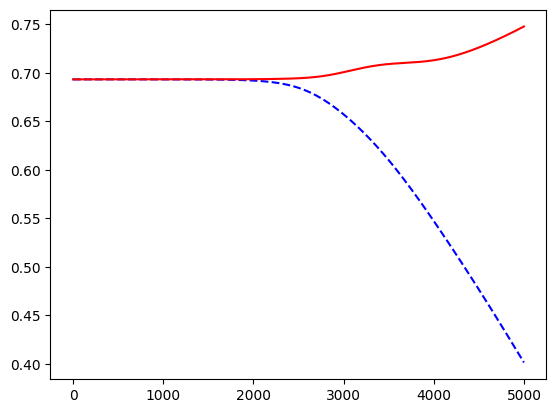

In [ ]:
def grad(prediction, target, params, feature_0, feature_1):
    """ Gradient function with sigmoid activation
    Args:
        prediction: model predicted value, a 2d array with shape (# samples, 1)
        target: labeled value from data set, a 2d array with shape (# samples, 1)
        feature: feature matrix, a 2d array with shape (# samples, # pixels)
    Returns:
        dL_dw: row vector of BCE loss partial derivatives w.r.t. weights, 2d array with shape (1, # features)
        dL_db: scalar of BCE loss partial derivatives w.r.t. bias
    """
    M = target.shape[0]
    dL_dw2 = 1 / M * np.dot((prediction - target).T, feature_1)
    dL_db2 = np.mean(prediction - target)
    dL_dX1 = np.dot((prediction - target), params['w_2'])
    dX1_dZ1 = feature_1 * (1 - feature_1)
    dL_dW1 = 1 / M * np.dot((dL_dX1 * dX1_dZ1).T, feature_0)
    dL_db1 = np.mean(dL_dX1 * dX1_dZ1, axis=0, keepdims=True)

    grads = {
        'dW_1': dL_dW1,
        'db_1': dL_db1,
        'dw_2': dL_dw2,
        'db_2': dL_db2,
    }
    return grads

# Initialize parameters
W1 = np.random.normal(loc=0., scale=0.0001, size=(128, feature_train.shape[1]))
b1 = np.random.normal(loc=0., scale=0.0001, size=(1, 128))
w2 = np.random.normal(loc=0., scale=0.0001, size=(1, 128))
b2 = np.random.normal(loc=0., scale=0.0001)
params = {'W_1': W1, 'b_1': b1, 'w_2': w2, 'b_2': b2}
num_iters = 5000
learning_rate = 0.007
losses_train, losses_test = [], []
# Optimization loop
for i in range(num_iters):
    # Evaluate model on train and test data
    pred_train, feature_1 = forward(feature_train, params)
    loss_train = binary_cross_entropy_loss(pred_train, target_train)
    pred_test, _ = forward(feature_test, params)
    loss_test = binary_cross_entropy_loss(pred_test, target_test)
    # Compute gradient
    grads = grad(pred_train, target_train, params, feature_train, feature_1)
    params['W_1'] = params['W_1'] - learning_rate * grads['dW_1']
    params['b_1'] = params['b_1'] - learning_rate * grads['db_1']
    params['w_2'] = params['w_2'] - learning_rate * grads['dw_2']
    params['b_2'] = params['b_2'] - learning_rate * grads['db_2']
    # Stats
    category_train = np.ones_like(pred_train)
    category_train[pred_train > 0.5] = 1
    category_train[pred_train <= 0.5] = 0
    acc_train = np.sum(category_train==target_train) / target_train.shape[0]
    category_test = np.ones_like(pred_test)
    category_test[pred_test > 0.5] = 1
    category_test[pred_test <= 0.5] = 0
    acc_test = np.sum(category_test==target_test) / target_test.shape[0]
    print(f"Iteration {i+1} training loss: {loss_train}, test loss: {loss_test} \ntrain accuracy: {acc_train}, test accuracy: {acc_test}")
    losses_train.append(loss_train)
    losses_test.append(loss_test)


plt.plot(range(num_iters), losses_train, 'b--', range(num_iters), losses_test, 'r')

The training loss keeps descreasing, but test loss even increased a little. This is a sign of over-fitting, which suggests to use a simpler model or employ more data.

## 8. Test
Download new images to this folder and try to use your model to classify them.


In [ ]:
image_raw = None  # read the raw image from a file
image_rgb = None  # Convert BGR to RGB
image_resize = None  # Resize image to shape (200, 200, 3)
image_flatten = None  # Flatten image array to a row vector with shape (1, 200*200*3)
image_rescale = None  # rescale pixel value from 0~255 to 0.~1.
dog_likelihood = None  # predict new image with your model

is_dog = dog_likelihood > 0.5
if is_dog.squeeze():
    print("It's dog!")
else:
    print("It's cat!")
